## <font color = 'darkblue'> **Etapas para chegar no melhor modelo de regressão para este projeto**

1) Executar uma boa Análise Exploratória

2) Avaliar os dados geográficos com Geopandas

3) Desenvolver notebook "padrão" para o projeto de Machine Learning, com funções que podem facilitar testes de diferentes modelos

4) **Aprimorar o modelo de Machine Learning, seguindo as etapas abaixo:**
    - Linear Regression com preprocessamento só colunas categóricas, comparando com Dummy Regressor
    - Avaliar se a transformação de target melhora modelo, e testar qual transformação de target é melhor (PowerTransform ou Quantile Transform)
    - Testar diferentes tipos de preprocessamento para colunas numéricas (somente RobustScaler ou Standard Scaler + Power Transform) com a melhor transformação de target
    - Aplicar Polynomial Features para verificar qual grau polinomial gera o melhor modelo
    - Substituir o Linear Regression pelo Elastic Net para verificar se a regularização dos dados melhora o modelo
    - **Substituir o ElasticNet pelo Ridge, testando os melhores parâmetros do modelo Ridge, e verificar os resultado para finalmente obter melhor modelo de regressão para esse projeto**

5) **Salvar o melhor modelo**

***OBS**: As etapas deste projeto executadas neste notebook estão destacadas de negrito*

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from joblib import dump

from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import PredictionErrorDisplay
from sklearn.model_selection import KFold, cross_validate, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OrdinalEncoder,
    OneHotEncoder,
    PolynomialFeatures,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
    QuantileTransformer,
)
from matplotlib.ticker import EngFormatter

from src.config import DADOS_LIMPOS, PASTA_RELATORIOS

RANDOM_STATE = 42
PALETTE = "coolwarm"
SCATTER_ALPHA = 0.2

In [2]:
df = pd.read_parquet(DADOS_LIMPOS)

df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,median_income_cat,rooms_per_household,population_per_household,bedrooms_per_room
0,-122.230003,37.880001,41,880,129,322,126,8.3252,452600,NEAR BAY,5,6.984127,2.555556,0.146591
1,-122.220001,37.860001,21,7099,1106,2401,1138,8.3014,358500,NEAR BAY,5,6.238137,2.109842,0.155797
2,-122.260002,37.840000,42,2555,665,1206,595,2.0804,226700,NEAR BAY,2,4.294117,2.026891,0.260274
3,-122.260002,37.849998,50,1120,283,697,264,2.1250,140000,NEAR BAY,2,4.242424,2.640152,0.252679
4,-122.260002,37.840000,50,2239,455,990,419,1.9911,158700,NEAR BAY,2,5.343676,2.362768,0.203216


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17564 entries, 0 to 17563
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   longitude                 17564 non-null  float32 
 1   latitude                  17564 non-null  float32 
 2   housing_median_age        17564 non-null  int8    
 3   total_rooms               17564 non-null  int16   
 4   total_bedrooms            17564 non-null  int16   
 5   population                17564 non-null  int16   
 6   households                17564 non-null  int16   
 7   median_income             17564 non-null  float32 
 8   median_house_value        17564 non-null  int32   
 9   ocean_proximity           17564 non-null  category
 10  median_income_cat         17564 non-null  int64   
 11  rooms_per_household       17564 non-null  float32 
 12  population_per_household  17564 non-null  float32 
 13  bedrooms_per_room         17564 non-null  floa

#### **Fórmulas usadas para geração e avaliação dos modelos de machine learning deste projeto**

OBS: Expandir a célula abaixo caso queira consultar as fórmulas

In [4]:
# Função para construir o pipeline do modelo d e regressão, caso exista ou não etapas de preprocessamento e transformação de target
def construir_pipeline_modelo_regressao(
    regressor, preprocessor=None, target_transformer=None
):
    if preprocessor is not None:
        pipeline = Pipeline([("preprocessor", preprocessor), ("reg", regressor)])
    else:
        pipeline = Pipeline([("reg", regressor)])

    if target_transformer is not None:
        model = TransformedTargetRegressor(
            regressor=pipeline, transformer=target_transformer
        )
    else:
        model = pipeline
    return model

# Função treinar o modelo de regressão e retornar os scores da validação cruzada
def treinar_e_validar_modelo_regressao(
    X,
    y,
    regressor,
    preprocessor=None,
    target_transformer=None,
    n_splits=5,
    random_state=RANDOM_STATE,
):

    model = construir_pipeline_modelo_regressao(
        regressor, preprocessor, target_transformer
    )

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    scores = cross_validate(
        model,
        X,
        y,
        cv=kf,
        scoring=[
            "r2",
            "neg_mean_absolute_error",
            "neg_root_mean_squared_error",
        ],
    )

    return scores

# Após aplicar a função "treinar_e_validar_modelo_regressao" é aplicado essa função para obter um dataframe com as métricas de avaliação do modelo de regressão de acordo com a validação cruzada
def organiza_resultados(resultados):

    for chave, valor in resultados.items():
        resultados[chave]["time_seconds"] = (
            resultados[chave]["fit_time"] + resultados[chave]["score_time"]
        )

    df_resultados = (
        pd.DataFrame(resultados).T.reset_index().rename(columns={"index": "model"})
    )

    df_resultados_expandido = df_resultados.explode(
        df_resultados.columns[1:].to_list()
    ).reset_index(drop=True)

    try:
        df_resultados_expandido = df_resultados_expandido.apply(pd.to_numeric)
    except ValueError:
        pass

    return df_resultados_expandido

# Após aplicar a função "organiza_resultados(resultados)" é aplicado essa função para transformar os dados do dataframe em 4 gráficos
def plot_comparar_metricas_modelos(df_resultados):
    fig, axs = plt.subplots(2, 2, figsize=(8, 8), sharex=True)

    comparar_metricas = [
        "time_seconds",
        "test_r2",
        "test_neg_mean_absolute_error",
        "test_neg_root_mean_squared_error",
    ]

    nomes_metricas = [
        "Tempo (s)",
        "R²",
        "MAE",
        "RMSE",
    ]

    for ax, metrica, nome in zip(axs.flatten(), comparar_metricas, nomes_metricas):
        sns.boxplot(
            x="model",
            y=metrica,
            data=df_resultados,
            ax=ax,
            showmeans=True,
        )
        ax.set_title(nome)
        ax.set_ylabel(nome)
        ax.tick_params(axis="x", rotation=90)

    plt.tight_layout()

    plt.show()

# Função criada para utilizar a ferramenta grid_search para obter quais são os melhores parâmetros para o modelo de machine learning
def grid_search_cv_regressor(
    regressor,
    param_grid,
    preprocessor=None,
    target_transformer=None,
    n_splits=5,
    random_state=RANDOM_STATE,
    return_train_score=False,
):
    model = construir_pipeline_modelo_regressao(
        regressor, preprocessor, target_transformer
    )

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    grid_search = GridSearchCV(
        model,
        cv=kf,
        param_grid=param_grid,
        scoring=["r2", "neg_mean_absolute_error", "neg_root_mean_squared_error"],
        refit="neg_root_mean_squared_error",
        n_jobs=-1,
        return_train_score=return_train_score,
        verbose=1,
    )

    return grid_search

# Obter os coeficientes da regressão logística do modelo obtido
def dataframe_coeficientes(coefs, colunas):
    return pd.DataFrame(data=coefs, index=colunas, columns=["coeficiente"]).sort_values(
        by="coeficiente"
    )

# Plotar os coeficientes da regressão logística acima
def plot_coeficientes(df_coefs, tituto="Coeficientes"):
    df_coefs.plot.barh()
    plt.title(tituto)
    plt.axvline(x=0, color=".5")
    plt.xlabel("Coeficientes")
    plt.gca().get_legend().remove()
    plt.show()

# Após ter definido o melhor modelo, é aplicado essa formula para comparar os dados previstos com os dados de teste
def plot_residuos_estimador(estimator, X, y, eng_formatter=False, fracao_amostra=0.25):

    fig, axs = plt.subplots(1, 3, figsize=(12, 6))

    error_display_01 = PredictionErrorDisplay.from_estimator(
        estimator,
        X,
        y,
        kind="residual_vs_predicted",
        ax=axs[1],
        random_state=RANDOM_STATE,
        scatter_kwargs={"alpha": SCATTER_ALPHA},
        subsample=fracao_amostra,                       # Mostra o percentual dos dados que serão exibidos no gráfico
    )

    error_display_02 = PredictionErrorDisplay.from_estimator(
        estimator,
        X,
        y,
        kind="actual_vs_predicted",
        ax=axs[2],
        random_state=RANDOM_STATE,
        scatter_kwargs={"alpha": SCATTER_ALPHA},
        subsample=fracao_amostra,
    )

    residuos = error_display_01.y_true - error_display_01.y_pred

    sns.histplot(residuos, kde=True, ax=axs[0])

    if eng_formatter:                                              # É só pra melhorar a legenda dos eixos X e y, em vez de deixar 100000 e 20000 fica 100k e 200k
        for ax in axs:
            ax.yaxis.set_major_formatter(EngFormatter())
            ax.xaxis.set_major_formatter(EngFormatter())

    plt.tight_layout()

    plt.show()

#### **Separação das colunas do dataframe**

In [5]:
coluna_target = ['median_house_value']

coluna_one_hot_encoder = ['ocean_proximity']

coluna_ordinal_enconder = ['median_income_cat']

In [6]:
colunas_robust_scaler = df.columns.difference(coluna_target + coluna_one_hot_encoder + coluna_ordinal_enconder)
colunas_robust_scaler

Index(['bedrooms_per_room', 'households', 'housing_median_age', 'latitude',
       'longitude', 'median_income', 'population', 'population_per_household',
       'rooms_per_household', 'total_bedrooms', 'total_rooms'],
      dtype='object')

In [7]:
X = df.drop(columns=coluna_target)
y = df[coluna_target]

#### **Definido o *"Preprocessamento Simples"* no notebook anterior para aplicar o *"Polynomial Features"*** 
- Foi o preprocessamento que trouxe melhores resultados pelo GridSearch no notebook anterior
- **OBS:** PolynomialFeatures() é uma etapa de *PREPROCESSAMENTO* dentro do Pipeline, pode até ser usada como um regressor, mas nesse exemplo está sendo usada junto com o modelo de LinearRegression </font>

In [8]:
pipeline_robust = Pipeline(steps = [
    ('robust_scaler', RobustScaler()),
    ('poly', PolynomialFeatures(degree=1, include_bias=False))             # Inicialmente será grau 1, mas vamos testar outros graus com o grid search
])

preprocessamento = ColumnTransformer(
    transformers = [
        ('one_hot_encoder', OneHotEncoder(drop='first'), coluna_one_hot_encoder),         # drop='first' --> Para reduzir o número de colunas no preprocessamento
        ('ordinal_encoder', OrdinalEncoder(categories='auto'), coluna_ordinal_enconder),
        ('robust_scaler_poly', pipeline_robust, colunas_robust_scaler)      
    ],
)

In [9]:
preprocessamento

ColumnTransformer(transformers=[('one_hot_encoder', OneHotEncoder(drop='first'),
                                 ['ocean_proximity']),
                                ('ordinal_encoder', OrdinalEncoder(),
                                 ['median_income_cat']),
                                ('robust_scaler_poly',
                                 Pipeline(steps=[('robust_scaler',
                                                  RobustScaler()),
                                                 ('poly',
                                                  PolynomialFeatures(degree=1,
                                                                     include_bias=False))]),
                                 Index(['bedrooms_per_room', 'households', 'housing_median_age', 'latitude',
       'longitude', 'median_income', 'population', 'population_per_household',
       'rooms_per_household', 'total_bedrooms', 'total_rooms'],
      dtype='object'))])

#### **Colocando parâmetros apenas do modelo Ridge para serem testados pelo GridSearchCV*** 

**OBS**: Esse modelo foi escolhido pois no notebook anterior o melhor modelo obtido pelo GridSearchCV foi do modelo ElasticNet com parâmetro do alpha = 0.01 (ElasticNet com alpha = 0 é o modelo Ridge)

In [10]:
param_grid = {
    'regressor__preprocessor__robust_scaler_poly__poly__degree': [1, 2, 3],
    'regressor__reg__alpha': [1E-2, 5E-2, 0.1, 0.25, 0.5, 1, 2, 5, 10, 20, 100],                     # Alpha = 0 o ElasticNet fica igual ao Linear Regression
}

In [11]:
grid_search = grid_search_cv_regressor(
    regressor= Ridge(),
    preprocessor = preprocessamento,             
    target_transformer = QuantileTransformer(output_distribution='normal'),                # Já foi definido no notebook anterior que o QuantileTransformer trouxe melhores resultados
    param_grid = param_grid
)

grid_search

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(transformers=[('one_hot_encoder',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity']),
                                                                                                             ('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat']),
                                                                                                             ('robust_scaler_poly',
                                                                                                              Pipeline(steps=[('robust_sc...
                                                                            ('reg',
                                                                             Ridge())]),
                                                  transformer=QuantileTransformer(output_distribution='normal')),
             n_jobs=-1,
             param_grid={'regressor__preprocessor__robust_scaler_poly__poly__degree': [1,
                                                                                       2,
                                                                                       3],
                         'regressor__reg__alpha': [0.01, 0.05, 0.1, 0.25, 0.5,
                                                   1, 2, 5, 10, 20, 100]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

In [12]:
grid_search.fit(X, y)

Fitting 5 folds for each of 33 candidates, totalling 165 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(transformers=[('one_hot_encoder',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity']),
                                                                                                             ('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat']),
                                                                                                             ('robust_scaler_poly',
                                                                                                              Pipeline(steps=[('robust_sc...
                                                                            ('reg',
                                                                             Ridge())]),
                                                  transformer=QuantileTransformer(output_distribution='normal')),
             n_jobs=-1,
             param_grid={'regressor__preprocessor__robust_scaler_poly__poly__degree': [1,
                                                                                       2,
                                                                                       3],
                         'regressor__reg__alpha': [0.01, 0.05, 0.1, 0.25, 0.5,
                                                   1, 2, 5, 10, 20, 100]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

In [13]:
grid_search.best_params_ 

{'regressor__preprocessor__robust_scaler_poly__poly__degree': 3,
 'regressor__reg__alpha': 10}

In [14]:
grid_search.best_score_

-50441.319879528295

In [15]:
grid_search.best_estimator_

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      ColumnTransformer(transformers=[('one_hot_encoder',
                                                                                       OneHotEncoder(drop='first'),
                                                                                       ['ocean_proximity']),
                                                                                      ('ordinal_encoder',
                                                                                       OrdinalEncoder(),
                                                                                       ['median_income_cat']),
                                                                                      ('robust_scaler_poly',
                                                                                       Pipeline(steps=[('robust_scaler',
                                                                                                        RobustScaler()),
                                                                                                       ('poly',
                                                                                                        PolynomialFeatures(degree=3,
                                                                                                                           include_bias=False))]),
                                                                                       Index(['bedrooms_per_room', 'households', 'housing_median_age', 'latitude',
       'longitude', 'median_income', 'population', 'population_per_household',
       'rooms_per_household', 'total_bedrooms', 'total_rooms'],
      dtype='object'))])),
                                                     ('reg', Ridge(alpha=10))]),
                           transformer=QuantileTransformer(output_distribution='normal'))

In [ ]:
coefs = dataframe_coeficientes(
    grid_search.best_estimator_.regressor_['reg'].coef_, 
    grid_search.best_estimator_.regressor_['preprocessor'].get_feature_names_out()
)
coefs

,coeficiente
robust_scaler_poly__longitude,-1.035587
robust_scaler_poly__latitude,-0.969135
one_hot_encoder__ocean_proximity_INLAND,-0.467670
robust_scaler_poly__latitude longitude population_per_household,-0.417919
robust_scaler_poly__population_per_household,-0.330157
...,...
robust_scaler_poly__bedrooms_per_room housing_median_age total_rooms,0.245659
robust_scaler_poly__housing_median_age median_income,0.247139
robust_scaler_poly__latitude^2 longitude,0.253443
robust_scaler_poly__bedrooms_per_room,0.338814


In [19]:
coefs[coefs['coeficiente'] == 0]        # Voltamos a não ter nenhum coeficiente zerado, pois agora estamos usando apenas o Ridge, e não tem mais efeito do Lasso dentro do Elasticnet

# Lasso --> zera os coeficiente de menor importância
# Ridget --> diminuir os coeficientes de menor importância, mas não tende a zerá-los

,coeficiente


In [20]:
coefs[coefs['coeficiente'].between(-0.2, 0.2)]        # Repare que temos 301 nessa faixa coeficientes entre essa 

,coeficiente
one_hot_encoder__ocean_proximity_NEAR BAY,-0.198669
robust_scaler_poly__housing_median_age population_per_household total_bedrooms,-0.194951
robust_scaler_poly__households median_income^2,-0.183345
robust_scaler_poly__longitude median_income,-0.182097
robust_scaler_poly__bedrooms_per_room rooms_per_household,-0.179851
...,...
robust_scaler_poly__total_bedrooms,0.169224
robust_scaler_poly__median_income population population_per_household,0.173442
robust_scaler_poly__bedrooms_per_room rooms_per_household total_bedrooms,0.174218
robust_scaler_poly__median_income population rooms_per_household,0.177076


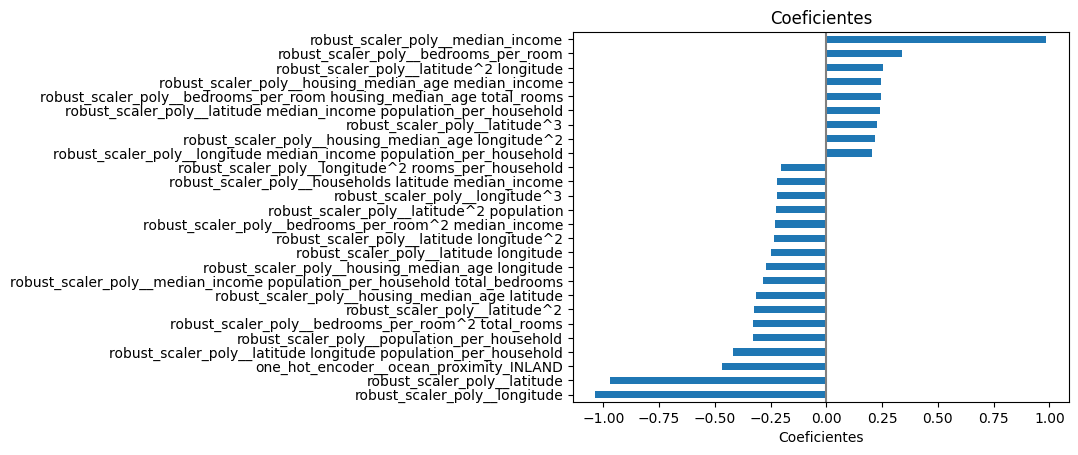

In [21]:
plot_coeficientes(coefs[~coefs['coeficiente'].between(-0.2, 0.2)])

# Veja que agora temos muitos coeficientes que são iguais às colunas originais do dataframe, 
# Ou seja, colocar um regularização pode ajudar a simplificar o modelo e torná-lo mais fácil de entender

#### **Comparando os modelos acima criados com o modelo com os melhores estimadores pelo GridSearchCV**

In [32]:
regressors = {
    "DummyRegressor": {
        'preprocessor': None,
        'regressor': DummyRegressor(strategy='mean'),
        'target_transformer': None
    },
    "LinearRegression": {
        'preprocessor': preprocessamento,
        'regressor': LinearRegression(),
        'target_transformer': None
    },
    "LinearReg + Target & Column Transformer": {    # Incluído esse regressor, pois aí a unica diferença pro GridSearch será as Polynomial Features (no proprocessamento tava definido grau 1)
        'preprocessor': preprocessamento,
        'regressor': LinearRegression(),
        'target_transformer': QuantileTransformer(output_distribution='normal')
    },
    "RidgeRegression_PolyFeat_GridSearchCV": {
        'preprocessor': grid_search.best_estimator_.regressor_['preprocessor'],
        'regressor': grid_search.best_estimator_.regressor_['reg'],
        'target_transformer': grid_search.best_estimator_.transformer
    }, 
}

In [33]:
resultados = {
    nome_modelo: treinar_e_validar_modelo_regressao(X, y, **regressor) for nome_modelo, regressor in regressors.items()
}

df_resultados = organiza_resultados(resultados)
df_resultados

,model,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
0,DummyRegressor,0.005984,0.008976,-0.000081,-77516.042766,-96239.705692,0.01496
1,DummyRegressor,0.005982,0.006983,-0.000146,-75787.787194,-95217.629397,0.012965
2,DummyRegressor,0.005984,0.007978,-0.001737,-76753.598961,-96253.253947,0.013962
3,DummyRegressor,0.005985,0.01496,-0.000101,-76837.804811,-95983.885799,0.020945
4,DummyRegressor,0.006978,0.012965,-0.000114,-76617.245449,-96182.764729,0.019943
5,LinearRegression,0.334772,0.023798,0.682162,-39855.690996,-54254.958188,0.35857
6,LinearRegression,0.274551,0.027926,0.66999,-40272.565467,-54695.230283,0.302477
7,LinearRegression,0.647738,0.030918,0.649247,-42178.05929,-56955.988706,0.678656
8,LinearRegression,0.301751,0.026008,0.669873,-40806.492497,-55146.318803,0.327758
9,LinearRegression,0.236809,0.019947,0.669023,-40788.496497,-55331.35106,0.256755


In [34]:
df_resultados.groupby('model').mean().sort_values(by='test_neg_root_mean_squared_error')

,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
model,,,,,,
DummyRegressor,0.006183,0.010372,-0.000436,-76702.495836,-95975.447913,0.016555
LinearRegression,0.359124,0.025719,0.668059,-40780.26095,-55276.769408,0.384843
LinearReg + Target & Column Transformer,0.316413,0.041078,0.678284,-38671.788906,-54414.734262,0.357492
RidgeRegression_PolyFeat_GridSearchCV,2.50777,0.067438,0.723257,-35342.387973,-50460.734318,2.575208


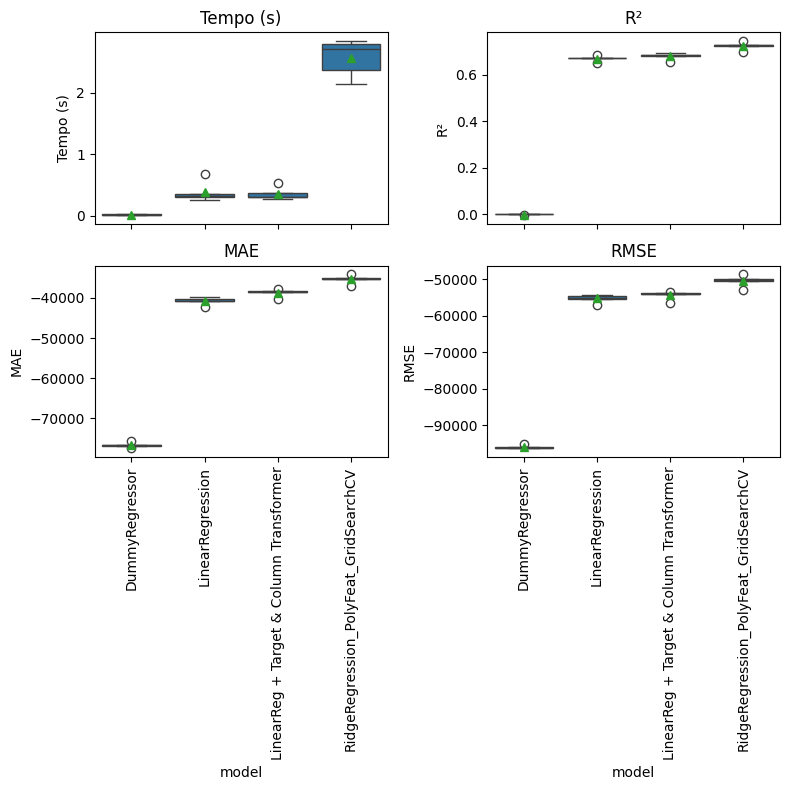

In [35]:
plot_comparar_metricas_modelos(df_resultados)

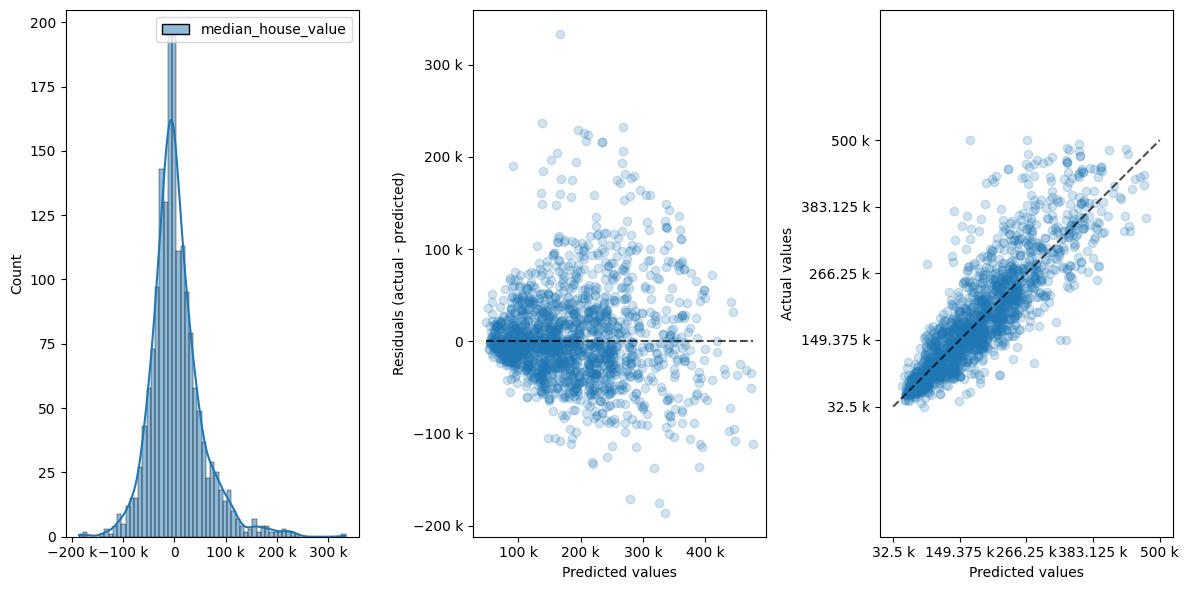

In [36]:
plot_residuos_estimador(grid_search.best_estimator_, X, y, fracao_amostra=0.1, eng_formatter=True)

### <font color = 'darkblue'> **Salvando o melhor modelo**

In [27]:
from pathlib import Path

# Pasta do noteook atual
Path().resolve()

WindowsPath('C:/Users/brcprrcchave/OneDrive - Blount/Documents/Treinamentos & Cursos/Ciência dos Dados Impressionador - Hashtag/Mod 14 - Regressao com Modelos Lineares/14.5 - Projeto de Regressão/notebooks')

In [28]:
# dump(grid_search.best_estimator_, Path().resolve().parents[0]/"modelos"/"ridge_polyfeat_target_quantile.joblib")

NameError: name 'dump' is not defined